<a href="https://colab.research.google.com/github/ViniSpeck/ML/blob/main/RFR_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
!pip install yfinance
!pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [203]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from scipy import stats
from numpy.random import randn
from numpy import random as rn
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import set_config
from matplotlib import pyplot as plt
import quandl as q
from datetime import datetime,date,timedelta
from calendar import monthrange
import seaborn as sns
%matplotlib inline

In [204]:
# Definindo parâmetros 
ticker = 'BTC-USD'
sp500_ticker = '^GSPC'
start_date = '2015-01-01'
end_date = date.today() - timedelta(days=1)

# Extraindo dados do token/ação desejada
df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
df = df.reindex(index=df.index[::-1])
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-28,16440.222656,16482.933594,16054.530273,16217.322266,16217.322266,27743025156
2022-11-27,16463.882812,16594.406250,16437.025391,16444.626953,16444.626953,20443898509
2022-11-26,16521.576172,16666.863281,16416.228516,16464.281250,16464.281250,18000008764
2022-11-25,16602.269531,16603.316406,16388.404297,16521.841797,16521.841797,18678255976
2022-11-24,16611.636719,16771.474609,16501.767578,16604.464844,16604.464844,26129037414


In [205]:
df.rename(columns={'Adj Close': 'Price'},inplace=True)
df

,Open,High,Low,Close,Price,Volume
Date,,,,,,
2022-11-28,16440.222656,16482.933594,16054.530273,16217.322266,16217.322266,27743025156
2022-11-27,16463.882812,16594.406250,16437.025391,16444.626953,16444.626953,20443898509
2022-11-26,16521.576172,16666.863281,16416.228516,16464.281250,16464.281250,18000008764
2022-11-25,16602.269531,16603.316406,16388.404297,16521.841797,16521.841797,18678255976
2022-11-24,16611.636719,16771.474609,16501.767578,16604.464844,16604.464844,26129037414
...,...,...,...,...,...,...
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400


In [206]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Price     0
Volume    0
dtype: int64

In [207]:
# Pegando os dados do rendimento do tesouro americano para definir a variável de renda fixa.
treasury = q.get('USTREASURY/YIELD', trim_start=start_date, returns='pandas')
df2 = pdr.get_data_yahoo([sp500_ticker], start=start_date, end=end_date)

df2.rename(columns={'Adj Close': 'US Treasury'},inplace=True)

conc_df = pd.concat([df, df2['US Treasury']], axis=1)
conc_df['US Treasury'].interpolate(method='linear', inplace=True)

[*********************100%***********************]  1 of 1 completed


In [208]:
conc_df['US Treasury'].fillna(value=0,inplace=True)
conc_df.head(10)

,Open,High,Low,Close,Price,Volume,US Treasury
Date,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,0.000000
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,2058.199951
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,2045.659953
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,2033.119954
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,2020.579956
2015-01-06,274.610992,287.553009,272.696014,286.188995,286.188995,23245700,2002.609985
2015-01-07,286.076996,298.753998,283.079010,294.337006,294.337006,24866800,2025.900024
2015-01-08,294.135010,294.135010,282.174988,283.348999,283.348999,19982500,2062.139893
2015-01-09,282.382996,291.114014,280.532990,290.407990,290.407990,18718600,2044.810059


In [209]:
y = conc_df['Price']
conc_df.drop(['Price'], axis=1,inplace=True)
x = conc_df

x = scale(x)
y = scale(y)

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.10)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


In [210]:
set_config(print_changed_only=False) 
 
rfr = RandomForestRegressor()
 
results = rfr.fit(xtrain, ytrain)

score = rfr.score(xtrain, ytrain)
print("R-squared:", score) 

R-squared: 0.999996794233956


In [211]:
ypred = rfr.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

MSE:  6.903506152310657e-05
RMSE:  3.451753076155329e-05


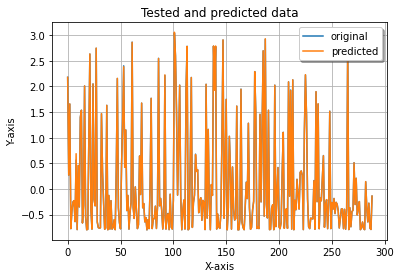

In [212]:
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Tested and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()